In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# %load mapper.py
import sys, os, time

# ----------------------------------------------------------
#sys.path.append("%s/tigress-dustpol-master/" % os.getcwd())
sys.path.append(os.getcwd())
# ----------------------------------------------------------

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from vtk_reader import *
import set_units
from physical_dust import HD_dust_model

units      = set_units.set_units(muH=1.4271)
dust_model = HD_dust_model('./')
ds         = AthenaDataSet('./R8_8pc_rst.rad.0300.vtk')

if (0):
    # This reads the data... and dumps to plain binary files for faster access
    dsmhd      = AthenaDataSet('./R8_8pc_rst.0300.vtk')
    for k,v in ds.domain.items():
        if k != 'field_map': print(k,v)
    # read hydrogen number density and radiation energy density from './R8_8pc_rst.rad.0300.vtk' file
    # note that rad_energy_density0 is EUV field
    nH       =  ds.read_all_data('density')     #   (986, 128, 128)
    print("nH ", nH.shape)
    E_FUV    =  ds.read_all_data('rad_energy_density1')
    # converting radiation energy density to G0'
    J_FUV0   =  2.1e-4*au.erg/au.cm**2/au.s/au.sr
    J_FUV    =  E_FUV*(units['pressure']*ac.c/(4*np.pi*au.sr)).cgs
    G0prime  =  np.array((J_FUV/J_FUV0).cgs)
    # calculate S_nu at 353 GHz using Brandon's dust model
    freq     =  353
    Snu      =  dust_model.calculate_Snu(nH,G0prime,freq,deltas=ds.domain['dx'][0])
    print("Snu ", nH.shape)
    # read in magnetic fields from './R8_8pc_rst.0300.vtk' file
    B        =  dsmhd.read_all_data('magnetic_field')
    Bx, By, Bz  = B[...,0].copy(), B[...,1].copy(), B[...,2].copy()  # must be contiguous in memory...
    le       =  ds.domain['left_edge']
    re       =  ds.domain['right_edge']
    if (0):
        fig,axes =  plt.subplots(1,3,figsize=(15,5))
        extent   =  [le[0],re[0],le[1],re[1]]
        axes[0].imshow(nH.sum(axis=0),norm=LogNorm(),extent=extent)
        axes[1].imshow(G0prime.sum(axis=0),norm=LogNorm(),extent=extent)
        axes[2].imshow(Snu.value.sum(axis=0),norm=LogNorm(),extent=extent)
        plt.show()
    # dump RT data to plain binary files
    NZ, NY, NX = nH.shape   # we call the indices (z,y,x)
    fp = open('test.nH', 'wb')
    np.asarray([NZ, NY, NX], np.int32).tofile(fp)
    np.asarray(nH,  np.float32).tofile(fp)
    fp.close()
    np.asarray(Snu, np.float32).tofile('test.Snu')
    np.asarray(Bx,  np.float32).tofile('test.Bx')
    np.asarray(By,  np.float32).tofile('test.By')
    np.asarray(Bz,  np.float32).tofile('test.Bz')
    # sys.exit()
else:
    # This loads previously saved nH, Snu, Bx, By, Bz
    NZ, NY, NX = np.fromfile('test.nH', np.int32, 3)
    nH  = np.fromfile('test.nH' , np.float32)[3:].reshape(NZ, NY, NX)
    Snu = np.fromfile('test.Snu', np.float32)
    Bx  = np.fromfile('test.Bx',  np.float32)
    By  = np.fromfile('test.By',  np.float32)
    Bz  = np.fromfile('test.Bz',  np.float32)
    

In [3]:
qshear=1
Omega=0.028
vsh=-qshear*Omega*ds.domain['Lx'][0]
yshear=(vsh*ds.domain['time']) % ds.domain['Lx'][1]
jshear=yshear/ds.domain['dx'][1]

NameError: name 'le' is not defined

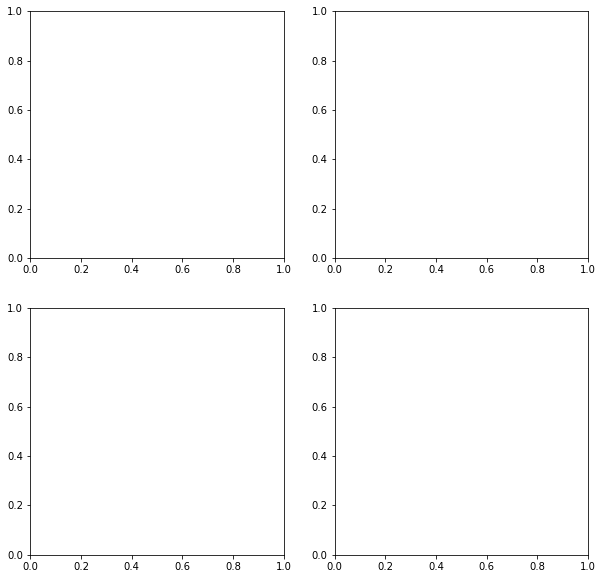

In [5]:
fig,axes =  plt.subplots(2,2,figsize=(10,10))
extent   =  [le[0],re[0],le[1],re[1]]
axes=axes.flatten()
axes[0].imshow(nH.sum(axis=0),norm=LogNorm(),extent=extent)
axes[1].imshow(G0prime.sum(axis=0),norm=LogNorm(),extent=extent)
axes[2].imshow(Snu.value.sum(axis=0),norm=LogNorm(),extent=extent)
axes[3].imshow((Snu/nH).value.sum(axis=0),norm=LogNorm(),extent=extent)
plt.show()

In [4]:
    
# ========================================================================================
GPU    =  1                   # GPU=0 => use CPU, GPU=1 => use GPU
dx     =  ds.domain['dx'][0]  # Cell size [pc]
nside  =  128                # Healpix size parameter, 12*nside*nside pixels
ext    =   0.0                # Extinction  [1/pc] for unit H density
obspos =  [1.0, 1.0, 1.0]     # Position of the observer (x,y,z) [pc] relative to the centre of the cube
maxlos = 2048.

In [5]:
from old_mapmaker import los_dump_from_data,calc_IQU

domain=ds.domain
domain['shear']=False
domain['qshear']=1.0
domain['Omega']=0.028
domain['fields']=['density','magnetic_field1','magnetic_field2','magnetic_field3']

Nside=nside
center=obspos
smax=maxlos

for data,field in zip([nH,Bx,By,Bz],['density','magnetic_field1','magnetic_field2','magnetic_field3']):
    los_dump_from_data(data,domain,dx,smax,field,Nside=Nside,center=center,force_write=False)
los_dump_from_data(Snu.value,domain,dx,smax,'Snu',Nside=Nside,center=center,force_write=False)

AttributeError: 'numpy.ndarray' object has no attribute 'value'

/Users/ckim/miniconda3/lib/python3.7/site-packages/pyopencl/__init__.py:231: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) UHD Graphics 630' on 'Apple' at 0x7fb1fc0aa610> succeeded, but said:

<program source>:10:5: warning: no previous prototype for function 'Angles2PixelRing'
int Angles2PixelRing(float phi, float theta) {
    ^
<program source>:52:6: warning: no previous prototype for function 'Pixel2AnglesRing'
bool Pixel2AnglesRing(const int ipix, float *phi, float *theta) {
     ^
<program source>:95:5: warning: no previous prototype for function 'Index'
int Index(float3 *POS) {
    ^
<program source>:105:7: warning: no previous prototype for function 'GetStep'
float GetStep(float3 *POS, const float3 *DIR, int *ind) {
      ^
Build on <pyopencl.Device 'AMD Radeon Pro 555X Compute Engine' on 'Apple' at 0x7fb1fc015fa0> succeeded, but said:

<program source>:12:5: warning: no previous prototype for fun

PolHealpixMapper: 0.62 seconds


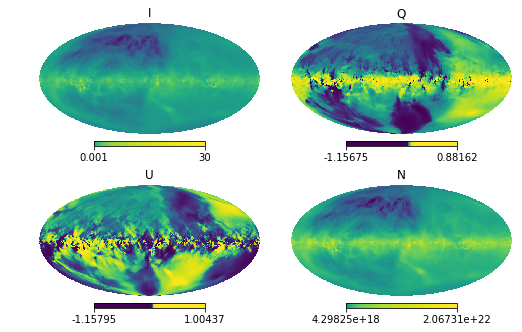

In [6]:
from HPmapper import *
import healpy


t0 = time.time()
# =====================================================================
# Convert Snu from MJy/sr/cell to  MJy/sr/H/pc as assumed by the kernel
Snu   = np.ravel(Snu)
Snu  /= np.ravel(nH)*dx
# =====================================================================
I, Q, U, N  = PolHealpixMapper(dx, nside, ext, obspos, nH, Snu, Bx, By, Bz, GPU=GPU,
                               y_shear=jshear, maxlos=maxlos, p0=0.2, polred=0)
print("PolHealpixMapper: %.2f seconds" % (time.time()-t0))
##  NSIDE=1024   CPU= 5.7 seconds, GPU=1.2 seconds
##  NSIDE=2048   CPU=20.1 seconds, GPU=2.2 seconds  ... 1.74 seconds with cached kernel
plt.figure(1, figsize=(7,4.5))
healpy.mollview(I, fig=1, sub=221, title='I', margins=[0.015, 0.020, 0.015, 0.02], norm='log', min=0.001, max=30.0)
healpy.mollview(Q, fig=1, sub=222, title='Q', margins=[0.015, 0.020, 0.015, 0.02], norm='hist')
healpy.mollview(-U, fig=1, sub=223, title='U', margins=[0.015, 0.020, 0.015, 0.02], norm='hist')
healpy.mollview(N, fig=1, sub=224, title='N', margins=[0.015, 0.020, 0.015, 0.02], norm='log')
plt.savefig('IQUN.png')

In [15]:
IQUN=calc_IQU(domain,dx,smax,Nside=Nside,center=center)

I_cgk=IQUN[0].sum(axis=1)
Q_cgk=IQUN[1].sum(axis=1)
U_cgk=IQUN[2].sum(axis=1)
N_cgk=IQUN[3].sum(axis=1)

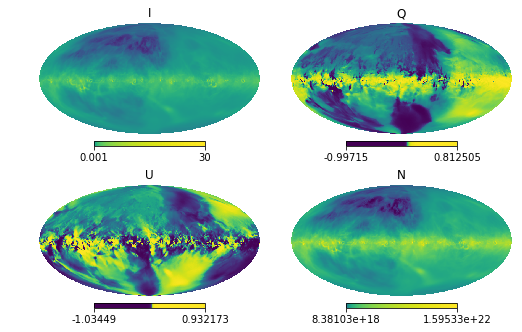

In [16]:
plt.figure(1, figsize=(7,4.5))
healpy.mollview(I_cgk, fig=1, sub=221, title='I', margins=[0.015, 0.020, 0.015, 0.02], norm='log', min=0.001, max=30.0)
healpy.mollview(Q_cgk, fig=1, sub=222, title='Q', margins=[0.015, 0.020, 0.015, 0.02], norm='hist')
healpy.mollview(U_cgk, fig=1, sub=223, title='U', margins=[0.015, 0.020, 0.015, 0.02], norm='hist')
healpy.mollview(N_cgk, fig=1, sub=224, title='N', margins=[0.015, 0.020, 0.015, 0.02], norm='log')
plt.savefig('IQUN_cgk.png')